In [1]:
%cd ..

/Users/pablomirallesgonzalez/Documents/masters-degree/Análisis de Redes Sociales/sna-ceb-assignment


In [2]:
import sys
sys.path.append('src')

In [156]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from networkx import community as nxcom
from cdlib.algorithms import leiden
from sklearn.metrics import normalized_mutual_info_score
from plots import (
    plot_circular_community_graph_with_reference,
    plot_bipartite_community_graph,
    get_color_str,
    community_list_to_dict,
    community_dict_to_list,
)

## Carga de datos

In [4]:
GRAPH_FILE = "data/amazon_graph.graphml"
graph = nx.read_graphml(GRAPH_FILE)

In [5]:
graph.number_of_nodes(), graph.number_of_edges()

(475, 1184)

Consideremos las comunidades reales:

In [117]:
node_to_community_real = {node: attr["community"] for node, attr in list(graph.nodes(data=True))}
real_communities = community_dict_to_list(node_to_community_real)
# sort by size (largest first)
real_communities = sorted(real_communities, key=len, reverse=True)
node_to_community_real = community_list_to_dict(real_communities)

## Algoritmo de Leiden

### Obtención de comunidades y de modularidad

In [27]:
# WARNING: I haven't been able to make this deterministic
leiden_communities = leiden(graph).communities

In [28]:
modularity = nxcom.modularity(graph, leiden_communities)
num_communities = len(leiden_communities)
print(f"Modularity: {modularity:.4f}")
print(f"Number of communities: {num_communities}")

Modularity: 0.8832
Number of communities: 19


### Visualización

Veamos algunas visualizaciones comparativas entre las comunidades obtenidas y las originales del *dataset*.

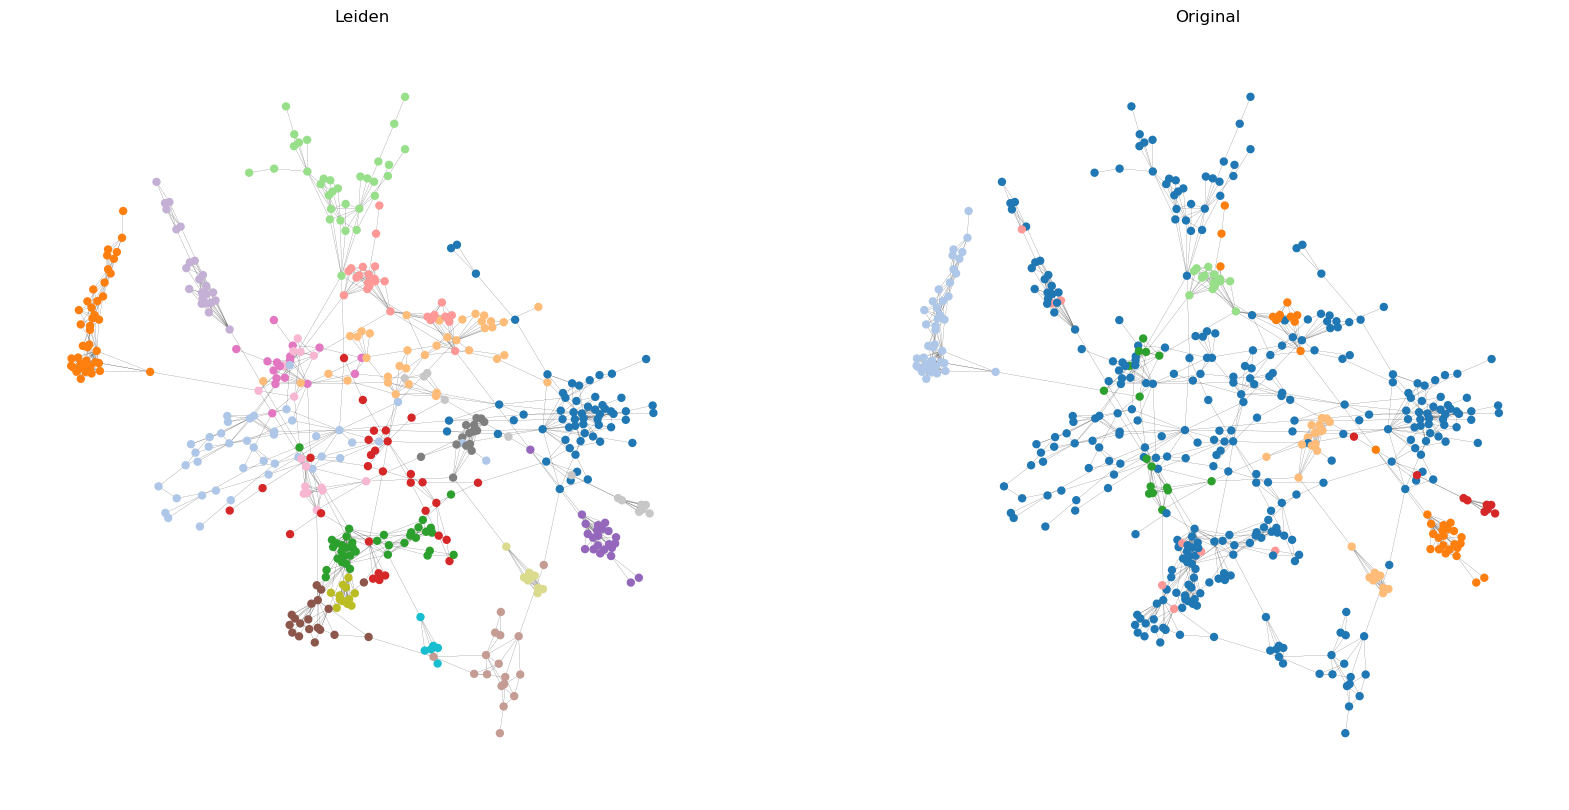

In [116]:
pos = nx.spring_layout(graph, seed=42)

# two plots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

node_to_community = community_list_to_dict(leiden_communities)
colors_leiden = [get_color_str(node_to_community[node]) for node in graph.nodes()]
nx.draw(graph, pos=pos, node_color=colors_leiden, node_size=25, width=0.1, with_labels=False, ax=ax1)

colors_orig = [get_color_str(node_to_community_real[node]) for node in graph.nodes()]
nx.draw(graph, pos=pos, node_color=colors_orig, node_size=25, width=0.1, with_labels=False, ax=ax2)

ax1.set_title("Leiden")
ax2.set_title("Original");

Vemos que en las comunidades originales hay una muy grande (verde) que se ha dividido en muchas.

Text(0.5, 1.0, 'Leiden - Community Graph')

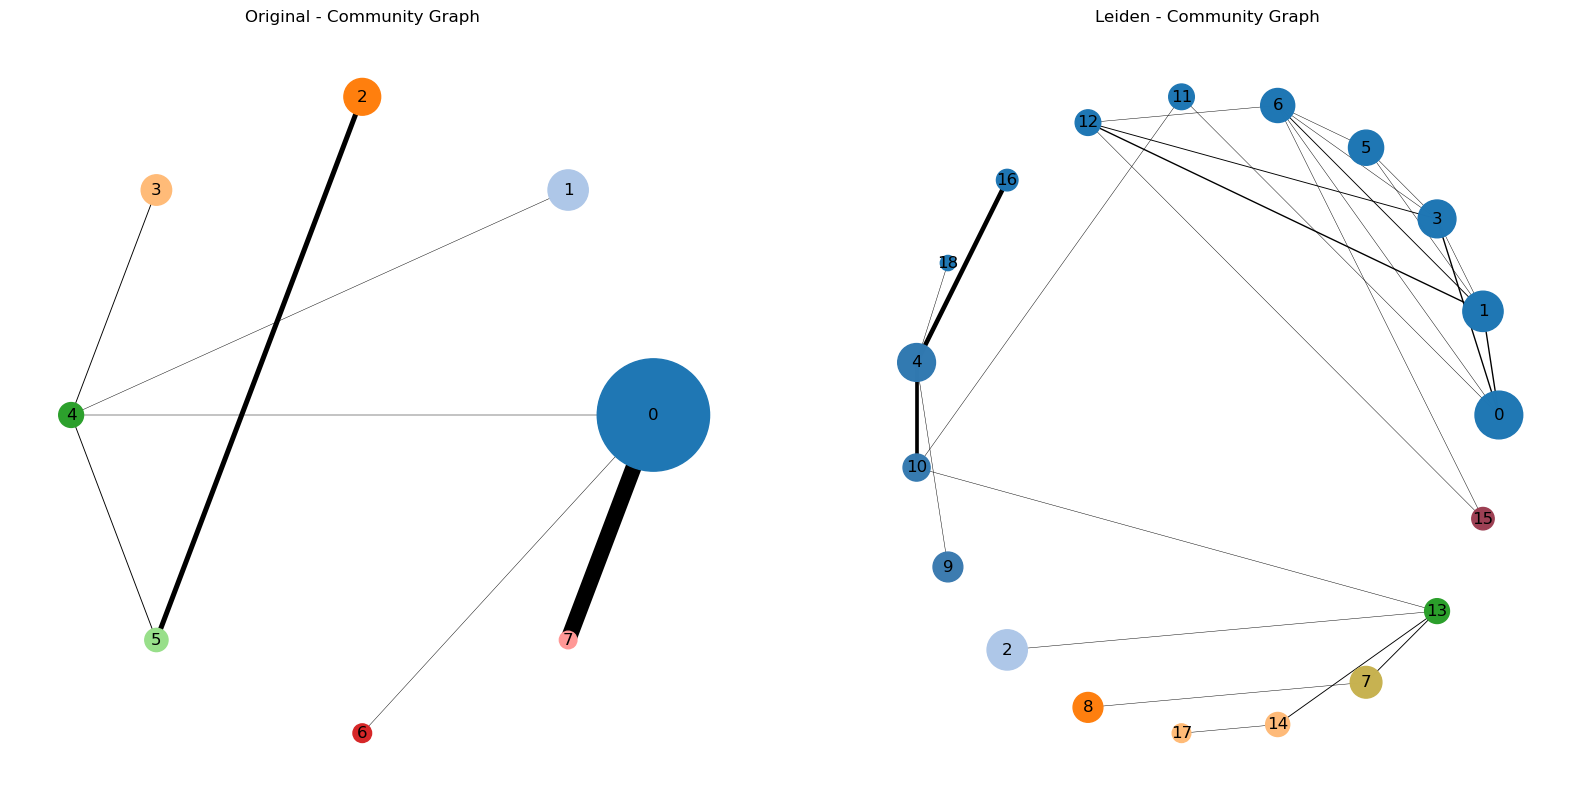

In [118]:
# two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_circular_community_graph_with_reference(
    graph,
    communities_1=real_communities,
    communities_2=leiden_communities,
    node_scale=20.,
    ax1=ax1,
    ax2=ax2,
)

ax1.set_title("Original - Community Graph");
ax2.set_title("Leiden - Community Graph")

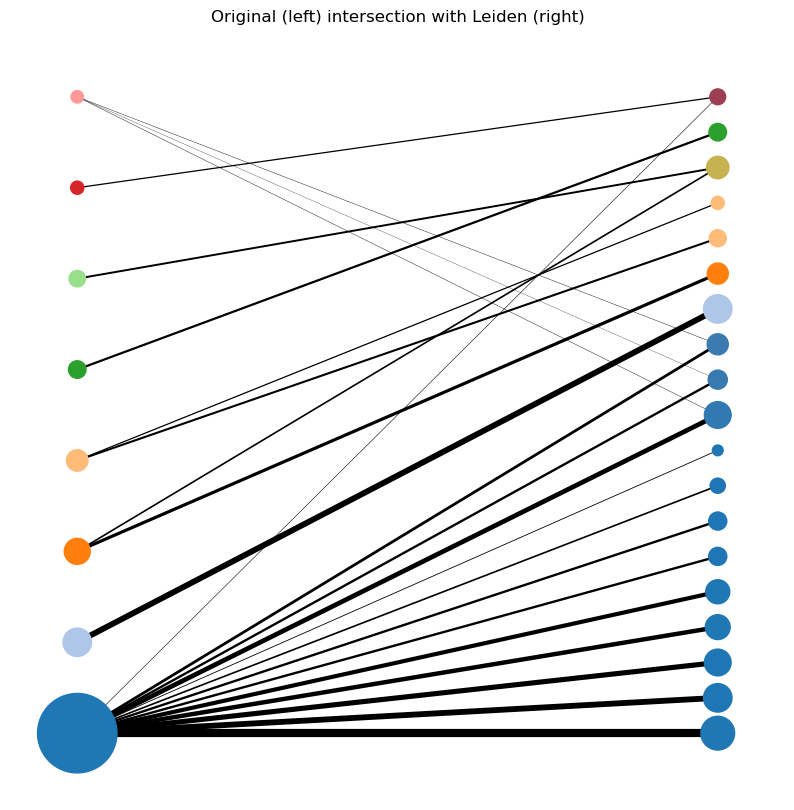

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_bipartite_community_graph(
    graph,
    communities_1=real_communities,
    communities_2=leiden_communities,
    node_scale=10.,
    edge_scale=0.1,
    ax=ax,
)

ax.set_title("Original (left) intersection with Leiden (right)");

Vemos que efectivamente la comunidad grande se ha dividido en muchas. Vemos otras tres comunidades pequeñas que quedan divididas (en 2, 2 y 3 comunidades). Además, en general vemos que las comunidades generadas por Leiden se corresponden a una sola comunidad original (14 de 18).

### Comparación con las comunidades preestablecidas
Además de las visualizaciones, podemos usar la métrica *normalized mutual information* para medir más objetivamente el parecido entre las comunidades detectadas.

In [121]:
# Convert the communities to lists of labels
original_communities_labels = [node_to_community_real[node] for node in graph.nodes()]
leiden_communities_labels = [node_to_community[node] for node in graph.nodes()]

# Calculate the normalized mutual information
nmi = normalized_mutual_info_score(original_communities_labels, leiden_communities_labels)
print(f"Normalized Mutual Information: {nmi:.4f}")

Normalized Mutual Information: 0.5362


Teniendo en cuenta que el valor está entre $0$ y $1$, obtenemos un resultado por la mitad. Son, por lo tanto, algo distintas. Tiene sentido con lo que hemos visto. En general, las comunidades de Leiden corresponden a una sola comunidad original, pero las comunidades originales quedan divididas, especialmente la grande, entre varias de Leiden.

## Discusión

Todo parece indicar un problema de resolución, como hemos visto en clase. Recordemos que la fórmula de la modularidad se puede escribir como:
$$
\sum_{i=1}^C e_{ii} - a_i^2,
$$
donde
* $e_{ij}$ es la fracción de aristas con un vértice en la comunidad $i$ y el otro en la $j$.
* $a_i$ es la fracción de aristas con algún vértice en la comunidad $i$.

Si nos fijamos, el primer término es $\sum_i e_{ii} = 1 - \sum_{i\neq j} e_{ij}$, es decir, que para maximizar el primer término buscamos minimizar la fracción de aristas entre comunidades. Es claro que para ello nos conviene juntar el máximo número de comunidades posible. Si solo hubiese una comunidad, obtendríamos el valor perfecto $1$. Respecto al segundo término, se puede descomponer como:
$$
\sum_{i=1}^C a_i^2 =
\frac{1}{(2m)^2} \sum_{i=1}^C \left( \sum_{n \in c_i} \delta(n)^2 + \sum_{n_1, n_2 \in c_i, n_1 \neq n_2} \delta(n_1) \delta(n_2) \right) 
.$$
La suma de los cuadrados es imposible de evitar, y el otro término depende de los grados de nodos en la misma comunidad. Si los grados son bajos, se considera que es poco probable que los nodos se crucen entre sí, y por lo tanto una arista entre ellos es significativa. En cualquier caso, es claro que si cada nodo formase una comunidad, este término se minimizaría. Por lo tanto, esta métrica busca un mayor número de comunidades.

Este *trade-off* se suele modular con un parámetro positivo $\gamma > 0$, de la siguiente forma:
$$
\sum_{i=1}^C e_{ii} - \gamma a_i^2
.$$
Cuando $\gamma$ es grande, el algoritmo tiende a dividir comunidades grandes, y en caso contrario a juntar comunidades pequeñas.

Probamos a modular este hiperparámetro, y nos quedamos con el que mejor valor de información mutua produzca.

Text(0, 0.5, 'Normalized Mutual Information')

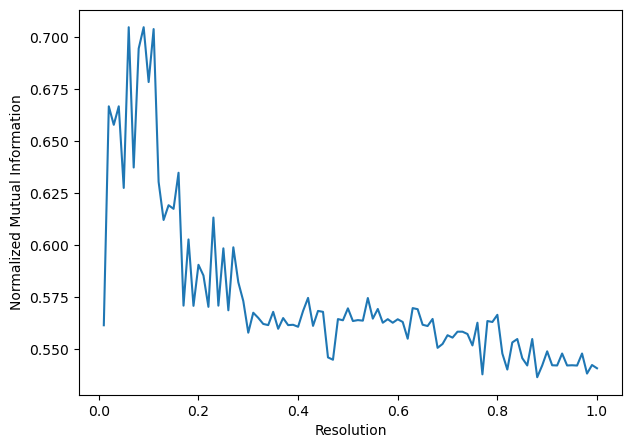

In [169]:
resolutions = np.arange(0.01, 1.01, 0.01)
nmi_scores = []

real_communities_labels = [node_to_community_real[node] for node in graph.nodes()]

for resolution in resolutions:
    louvain_communities = nxcom.louvain_communities(graph, resolution=resolution)
    node_to_community_louvain = community_list_to_dict(louvain_communities)
    louvain_communities_labels = [node_to_community_louvain[node] for node in graph.nodes()]

    nmi = normalized_mutual_info_score(real_communities_labels, louvain_communities_labels)
    nmi_scores.append(nmi)

# plot the nmi scores, each line is a different number of communities
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(resolutions, nmi_scores)
ax.set_xlabel("Resolution")
ax.set_ylabel("Normalized Mutual Information")

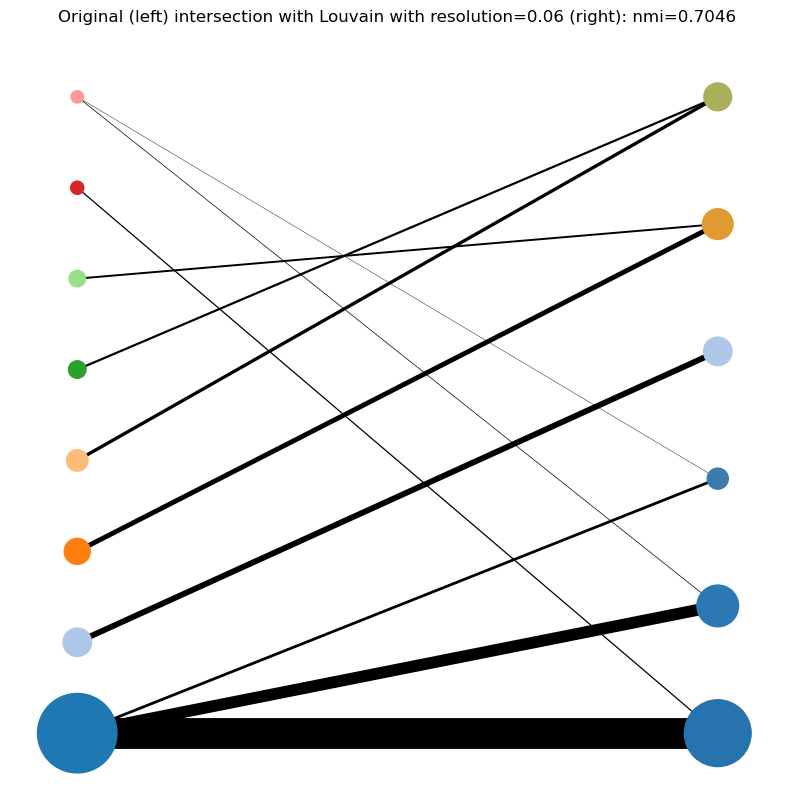

In [170]:
best_resolution = resolutions[np.argmax(nmi_scores)]
louvain_communities = nxcom.louvain_communities(graph, resolution=best_resolution)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_bipartite_community_graph(
    graph,
    communities_1=real_communities,
    communities_2=louvain_communities,
    node_scale=10.,
    edge_scale=0.1,
    ax=ax,
)

ax.set_title(f"Original (left) intersection with Louvain with resolution={best_resolution:.2f} (right): nmi={max(nmi_scores):.4f}");

Vemos una gran mejoría en cuanto a la comunidad grande, que ahora queda dividia en tres comunidades más grandes que antes. Sin embargo, vemos que ahora se han unido la tercera y la sexta desde abajo (en la partición real), y la cuarta y la quinta. Vemos que hemos llegado al punto en el que empezamos a juntar comunidades pequeñas. Parece entonces que no vamos a poder obtener mejores resultados con este método.

Finalmente, veamos como cambian según lo esperado las comunidades generadas en función de la resolución.

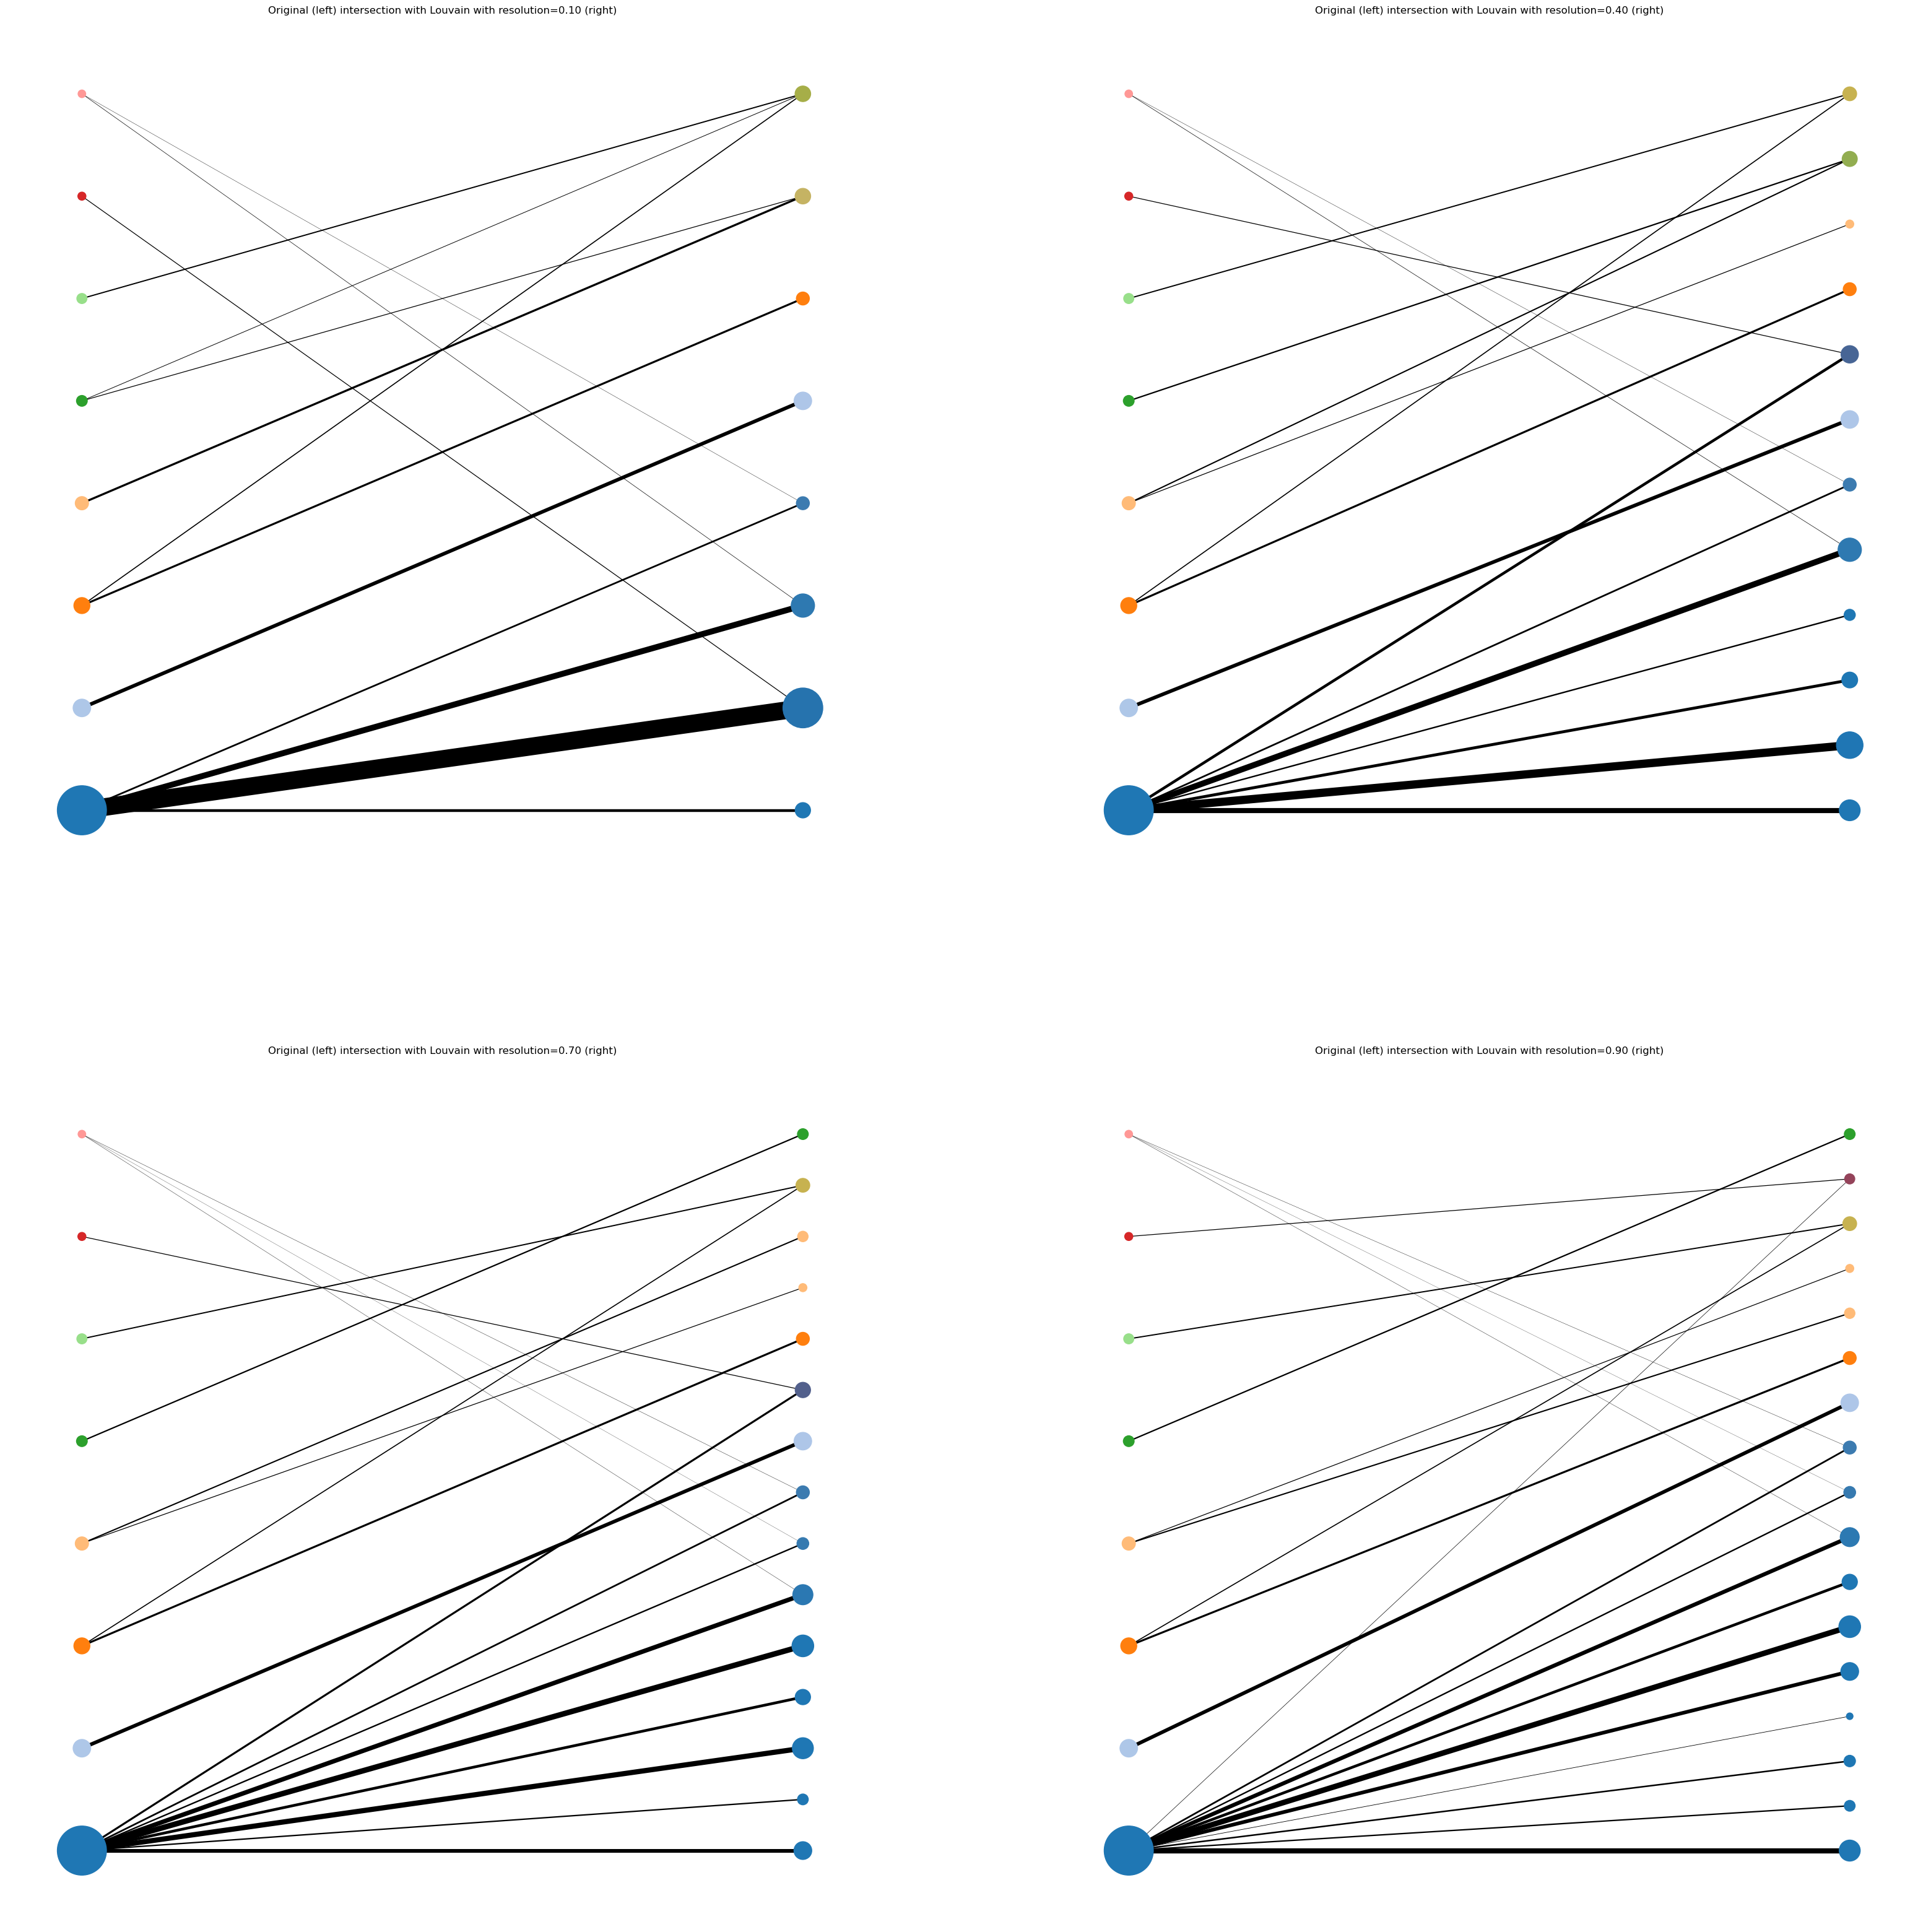

In [167]:
resolutions = [0.1, 0.4, 0.7, 0.9]

# plot solution for each resolution side by side
cols = 2
rows = (len(resolutions)+cols-1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20 * cols, 20 * rows))

for i, resolution in enumerate(resolutions):
    louvain_communities = nxcom.louvain_communities(graph, resolution=resolution)

    ax = axes[i // cols, i % cols]
    plot_bipartite_community_graph(
        graph,
        communities_1=real_communities,
        communities_2=louvain_communities,
        node_scale=10.,
        edge_scale=0.1,
        ax=ax,
    )

    ax.set_title(f"Original (left) intersection with Louvain with resolution={resolution:.2f} (right)");
